In [17]:
import pandas as pd
from collections import OrderedDict
import pytz
from zipline.api import *
import zipline
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import style
import talib
style.use("ggplot")

In [18]:
full_file_path = "SPY.csv"
data = OrderedDict()
data['SPY'] = pd.read_csv(full_file_path, index_col=0, parse_dates=['date'])
data['SPY'] = data['SPY'][["open","high","low","close","volume"]]
print(data['SPY'].head())

               open     high      low    close   volume
date                                                   
1993-01-29  43.9687  43.9687  43.7500  43.9375  1003200
1993-02-01  43.9687  44.2500  43.9687  44.2500   480500
1993-02-02  44.2187  44.3750  44.1250  44.3437   201300
1993-02-03  44.4062  44.8437  44.3750  44.8125   529400
1993-02-04  44.9687  45.0937  44.4687  45.0000   531500


In [19]:
panel = pd.Panel(data)
panel.minor_axis = ["open","high","low","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 6329 (major_axis) x 5 (minor_axis)
Items axis: SPY to SPY
Major_axis axis: 1993-01-29 00:00:00+00:00 to 2018-03-16 00:00:00+00:00
Minor_axis axis: open to volume


In [22]:
def initialize(context):
    set_max_leverage(1.0)
    set_benchmark(symbol("SPY"))


def handle_data(context, data):
    slowk, slowd = talib.STOCH(data['SPY']['high'],
                           data['SPY']['low'],
                           data['SPY']['close'],
                           fastk_period=5,
                           slowk_period=3,
                           slowk_matype=0,
                           slowd_period=3,
                           slowd_matype=0)


    # get the most recent value
    slowk = slowk[-1]
    slowd = slowd[-1]

    # If either the slowk or slowd are less than 10, the stock is 
    # 'oversold,' a long position is opened if there are no shares
    # in the portfolio.
    if slowk < 20 and slowd < 20 and slowk == slowd:
        order_target_percent(symbol('SPY'),1)

    # If either the slowk or slowd are larger than 90, the stock is 
    # 'overbought' and the position is closed. 
    elif slowk > 90 and slowd > 90 and slowk == slowd:
        order_target(symbol('SPY'), 0)

    record(SPY=data.current(symbol('SPY'), 'price'))
    
perf = zipline.run_algorithm(start=datetime(2017, 1, 5, 0, 0, 0, 0, pytz.utc),
                             end=datetime(2018, 3, 1, 0, 0, 0, 0, pytz.utc),
                             initialize=initialize,
                             capital_base=100000,
                             handle_data=handle_data,
                             data=panel)

/home/aidong/miniconda3/envs/zipline/lib/python3.5/site-packages/ipykernel_launcher.py:7: ZiplineDeprecationWarning: `data[sid(N)]` is deprecated. Use `data.current`.
  import sys
/home/aidong/miniconda3/envs/zipline/lib/python3.5/site-packages/ipykernel_launcher.py:8: ZiplineDeprecationWarning: `data[sid(N)]` is deprecated. Use `data.current`.
  
/home/aidong/miniconda3/envs/zipline/lib/python3.5/site-packages/ipykernel_launcher.py:9: ZiplineDeprecationWarning: `data[sid(N)]` is deprecated. Use `data.current`.
  if __name__ == '__main__':


TypeError: Argument 'high' has incorrect type (expected numpy.ndarray, got float)

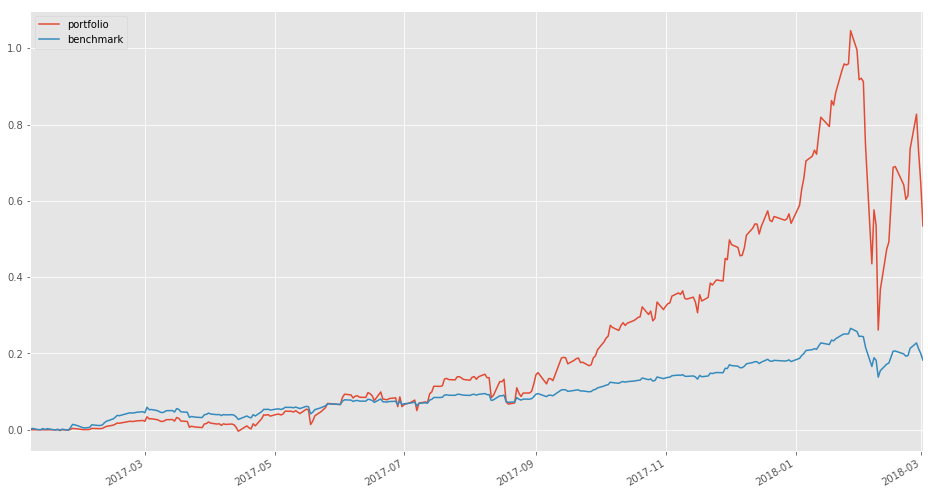

In [6]:
plt.figure(figsize=(16,9))
perf.portfolio_value.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='portfolio')
perf.SPY.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='benchmark')
plt.legend()

plt.show()

In [7]:
set_benchmark?